In [4]:
import glob
import os
import datetime as dt
import nltk
import numpy as np
import pandas as pd

from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
# from pyspark.sql.functions import col, udf, unix_timestamp
from textblob import TextBlob

https://github.com/Drabble/TwitterSentimentAndCryptocurrencies

In [161]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
from matplotlib import pyplot as plt

In [5]:
currency = [
    "DOGE"
    # "BTC",
    #"ETH",
    #"USDT",
    # "XRP",
    #"BCH",
    #"ADA",
    #"BSV",
    #"LTC",
    #"LINK",
    #"BNB",
    #"EOS",
    #"TRON",
]

In [123]:
class process_tweets():

    def __init__(self, tokenizer=None, stop_words=None, stemmer=None, lemmatizer=None):
        """ 
        Initialize the class.
        """
        self.path = Path(f'{os.getcwd()}')
        self.tokenizer = tokenizer
        self.stop_words = stop_words
        self.stemmer = stemmer
        self.lemmatizer = lemmatizer

        self.df = []
        self.vocabulary = []
        self.final = []

    # Read tweets from CSV for every currency
    def read_tweets(self, curr):
        """
        Read the tweets from the CSV file.
        """
        #initialize the dataframe
        aux = []
        ret = pd.DataFrame()
        for file in glob.glob(f"{self.path}/twitter_data/*/*-{curr}*.csv"):
            # print(f"Reading {file}")
            ret = pd.concat([pd.read_csv(file)], ignore_index=True)
            ret['coin_type'] = curr
            aux.append(ret)

        self.df = pd.concat(aux, ignore_index=True)
        # Print the number of rows
        print(f"Number of rows: {len(self.df)}")


    def clean_df(self):
        """
        Since I repeted the data mining multiple times, we expect duplicate of tweets.
        Keep the latess mined as the number of followers and retweets can chage.
        """
        self.df.sort_values(by=['created_at'], ascending=True)
        self.df.drop_duplicates(subset=['tweet_id'], keep='last', ignore_index=True)

        self.df.drop(columns=['tweet_id', 'name', 'screen_name', 'mined_at', 
                              'favourite_count', 'hashtags', 
                              'status_count', 'location', 
                              'source_device', 'retweet_text'], inplace=True)


        self.df['created_at'] = pd.to_datetime(self.df['created_at'], format='%Y-%m-%d %H:%M')
        # Round time by 1h
        self.df['round_time'] = self.df['created_at'].dt.round('1h')
        self.df['round_time'] = self.df['round_time'].dt.strftime('%Y-%m-%d %H:%M')


    def clean_text(self, text):
        """
        Clean the text.
        """
        count = 0
        # Tokenize the text
        tokens = self.tokenizer.tokenize(text)
        count += len(tokens)
        # Remove stop words
        tokens = [token for token in tokens if token not in self.stop_words]
        # Case Folding
        tokens = [token.lower() for token in tokens]
        # Lemmatize the text
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        # Add word to vocabulary
        self.vocabulary.extend(tokens)

        # Return the lemma text
        return " ".join(tokens), count

    def process_ccy(self):
        """
        Processes the currency data.
        """
        # Create a new column for text_clean and assign ""
        self.df["text_clean"] = ""

        count = 0
        # Create column for text_clean and process the text
        for index, row in self.df.iterrows():

            # Clean the text
            text_clean, words = self.clean_text(row['text'])
            count += words
            # Add the cleaned text to the dataframe
            self.df['text_clean'][index] = text_clean
        
        print(f"There are {count} words in the text")
        print(f"Number of unique words: {len(self.vocabulary)}")
    
    def drop_last(self):
        """
        Drop text and created_at columns.
        """
        self.df.drop(columns=['text', 'created_at'], inplace=True)


    def getSentiment(self, tweet) -> list:
        """
        Get the sentiment of the tweet.
        """
        analysis = TextBlob(tweet)

        return analysis.sentiment.polarity

    def set_sentiment_VADER(self):
        """
        Set the sentiment using VADER.
        """
        analyser = SentimentIntensityAnalyzer()
        compound = []
        for i, tweet in enumerate(tqdm(self.df['text_clean'])):
            compound.append(analyser.polarity_scores(tweet)['compound'])

        self.df['sentiment_VADER'] = compound

    def set_score(self):
        """
        Set the sentiment score.
        To calculate the score for each tweet, we use different variables to which we had a weight based on its importance.
        The compound column represents the sentiment of the tweets and its value is between -1 and 1.
        We also use the number of retweets, and the number of users that follow the tweet's author.
        """
        score = []
        for i, tweet in tqdm(self.df.iterrows(), total=self.df.shape[0]):
            score.append(tweet['sentiment_VADER'] * (tweet['followers_count'])) #* (tweet['retweet_count']+1))

        self.df['score'] = score


In [124]:
processed = process_tweets(RegexpTokenizer(r'\w+'), 
                           stop_words=stopwords.words('english'), 
                           stemmer=SnowballStemmer("english"), 
                           lemmatizer=WordNetLemmatizer()
                           )
# Read data and concatenate to dataframe
for curr in currency:
    processed.read_tweets(curr)

processed.clean_df()
processed.process_ccy()
processed.drop_last()

processed.set_sentiment_VADER()

# Create a dataframe with the sentiment
for curr in currency:
    processed.df['sentiment'] = processed.df['text_clean'].apply(processed.getSentiment)

processed.set_score()

# Rearange the columns 'coin_type', 'round_time', 'text_clean', 'sentiment'
processed.df = processed.df[['coin_type', 'round_time', 'text_clean','retweet_count', 'followers_count', 'sentiment_VADER', 'sentiment', 'score']]

# Rename the column round_time to date
processed.df.rename(columns={'round_time': 'date'}, inplace=True)

Number of rows: 66251


C:\Users\paulc\AppData\Local\Temp/ipykernel_21872/2718092006.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['text_clean'][index] = text_clean


There are 1398224 words in the text
Number of unique words: 1134537


100%|██████████| 66251/66251 [00:11<00:00, 5690.07it/s] 


In [125]:
print(processed.df.head())

  coin_type              date  \
0      DOGE  2022-01-14 08:00   
1      DOGE  2022-01-14 08:00   
2      DOGE  2022-01-14 08:00   
3      DOGE  2022-01-14 08:00   
4      DOGE  2022-01-14 08:00   

                                          text_clean  retweet_count  \
0  rt cryptoamore1 tct have heard wildcardgame wi...             71   
1  rt acecryptoinfo best project hold 2022 just l...             74   
2  rt whalestats which going spike month shib dog...            516   
3  rt cryptoamore1 tct have heard wildcardgame wi...             66   
4  here current situation doge coin nft doge elon...              0   

   followers_count  sentiment_VADER  sentiment     score  
0              626           0.7906       0.65  494.9156  
1              351           0.6369       1.00  223.5519  
2              248           0.0000       0.00    0.0000  
3              626           0.6249       0.80  391.1874  
4               78           0.0000       0.00    0.0000  


### Truncating dataframe by hour and then grouping them by hour

In [126]:
# Sort the dataframe by date
processed.df.sort_values(by=['date'], ascending=True, inplace=True)

# Print the first and last element in date column 
print(processed.df['date'].iloc[0])
print(processed.df['date'].iloc[-1])

2022-01-13 17:00
2022-01-14 22:00


In [127]:
# Create hourly_sentiment_df to store the sentiment data for each hour
hourly_score_df = pd.DataFrame(columns=['date', 'score'])

# for loop to get the mean of score for each hour
for hour in processed.df['date'].unique():
    score = processed.df[processed.df['date'] == hour]['score']
    mean_score= score.mean()

    # Create a dataframe with the mean sentiment for each hour
    hourly_score_df = hourly_score_df.append({'date': hour, 'score': mean_score}, ignore_index=True)

In [145]:
# Print first and last element in hourly_sentiment_df
print(hourly_score_df.iloc[0])
print(hourly_score_df.iloc[-1])

date     2022-01-13 17:00
score          232.456765
Name: 0, dtype: object
date     2022-01-14 22:00
score         1254.336807
Name: 29, dtype: object


### Read Market Prices #COIN

In [129]:
doge_price_data = pd.read_csv(f"{processed.path}/DOGE_price.csv")
doge_price_data.rename(columns={'time': 'date'}, inplace=True)
doge_price_data.date = doge_price_data.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M'))

In [152]:
# Merge the dataframes hourly_score_df and doge_price_data on date column
# merged_df = pd.merge(hourly_score_df, doge_price_data, on='date', how='outer')
# # Drop the 'Unamed: 0' column
# merged_df.drop(columns=['Unnamed: 0'], inplace=True)
# merged_df.fillna(0, inplace=True)

# print(merged_df)

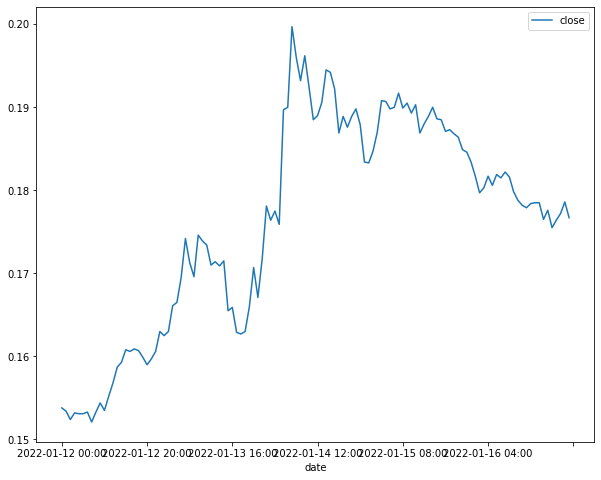

In [137]:
# Plot the doge_price_data for date and close columns
doge_price_data.plot(x='date', y=['close'], figsize=(10, 8))
plt.show()

## Plotting the score

In [149]:
# Plot the score for each hour
# fig, ax = plt.subplots(figsize=(20, 10))
# ax.set_title('Sentiment score for each hour', fontsize=20)
# ax.tick_params(labelsize=15)
# ax2 = ax.twinx()
# ax.plot(doge_price_data['date'], merged_df['score'], color='green', label='score')
# # ax2.plot(merged_df['date'], merged_df['close'], color='blue', label='price')

# # ax.plot(hourly_score_df['date'], hourly_score_df['score'], color='blue', linewidth=2)
# ax2.plot(doge_price_data['date'], doge_price_data['close'], color='blue', linewidth=2)

# # ax.set_ylabel('Sentiment score', fontsize=15, color='green')
# ax2.set_ylabel('DOGE price', fontsize=15, color='blue')
# plt.show()

### The following is sentiment not score

In [169]:
hourly_sentiment_df = pd.DataFrame()

# for loop to get the mean of sentiment for each hour
for hour in processed.df['date'].unique():
    # Get the sentiment for each hour
    sentiment = processed.df[processed.df['date'] == hour]['sentiment_VADER']
    mean_sentiment = sentiment.mean()

    # Create a dataframe with the mean sentiment for each hour
    hourly_sentiment_df = hourly_sentiment_df.append({'date': hour, 'sentiment': mean_sentiment}, ignore_index=True)

print(f"Head of the hourly sentiment dataframe: {hourly_sentiment_df.head()}")
print(f"Number of rows: {len(hourly_sentiment_df)}")

Head of the hourly sentiment dataframe:                date  sentiment
0  2022-01-13 17:00   0.206676
1  2022-01-13 18:00   0.175150
2  2022-01-13 19:00   0.187216
3  2022-01-13 20:00   0.190882
4  2022-01-13 21:00   0.197966
Number of rows: 30


### Process Market Price for #COINS to the same format

In [36]:
# from datetime import datetime

# ret = []
# for curr in currency:
#     for file in glob.glob(f"{processed.path}/market-price_data/{curr}*.csv"):
#         ret = pd.concat([pd.read_csv(file)], ignore_index=True)
#         ret['coin_type'] = curr

# # Rename column TIME to date
# ret.rename(columns={'TIME': 'date'}, inplace=True)
# ret.date = ret.date.apply(lambda x: datetime.strptime(x, '%d-%m-%y %H:%M:%S').strftime('%Y-%m-%d %H:%M'))

# # Drop columns that are not needed PAIR, TIME
# ret.drop(columns=['PAIR'], inplace=True)

# # Sort the dataframe by date ascending
# ret.sort_values(by=['date'], ascending=True, inplace=True) 
# # Rearange columns to match the dataframe
# doge_market_data = ret[['coin_type', 'date', 'BID', 'ASK']]


In [170]:
merged_df = pd.merge(hourly_sentiment_df, doge_price_data, on='date', how='outer')
# # Drop the 'Unamed: 0' column
merged_df.drop(columns=['Unnamed: 0'], inplace=True)
merged_df.fillna(0, inplace=True)

# Sort the dataframe by date ascending
merged_df.sort_values(by=['date'], ascending=True, inplace=True)

print(merged_df)

                 date  sentiment   close coin_type
30   2022-01-12 00:00        0.0  0.1538      DOGE
31   2022-01-12 01:00        0.0  0.1534      DOGE
32   2022-01-12 02:00        0.0  0.1524      DOGE
33   2022-01-12 03:00        0.0  0.1532      DOGE
34   2022-01-12 04:00        0.0  0.1531      DOGE
..                ...        ...     ...       ...
115  2022-01-16 19:00        0.0  0.1755      DOGE
116  2022-01-16 20:00        0.0  0.1764      DOGE
117  2022-01-16 21:00        0.0  0.1772      DOGE
118  2022-01-16 22:00        0.0  0.1786      DOGE
119  2022-01-16 23:00        0.0  0.1767      DOGE

[120 rows x 4 columns]


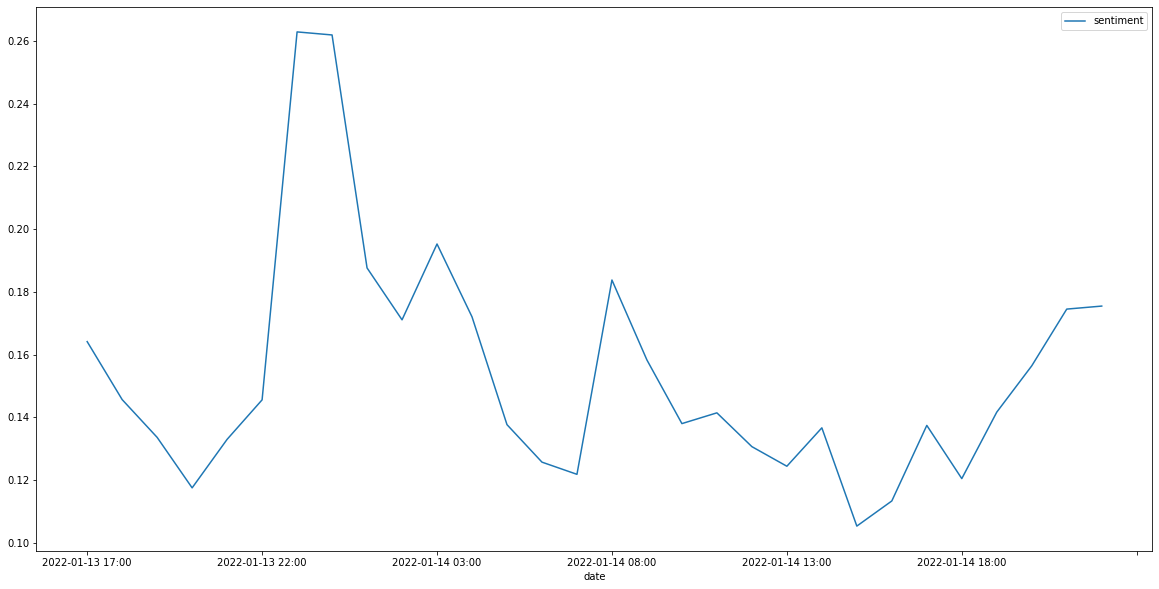

In [167]:
# Plot the hour sentiment dataframe
hourly_sentiment_df.plot(x='date', y='sentiment', figsize=(20, 10))
plt.show()

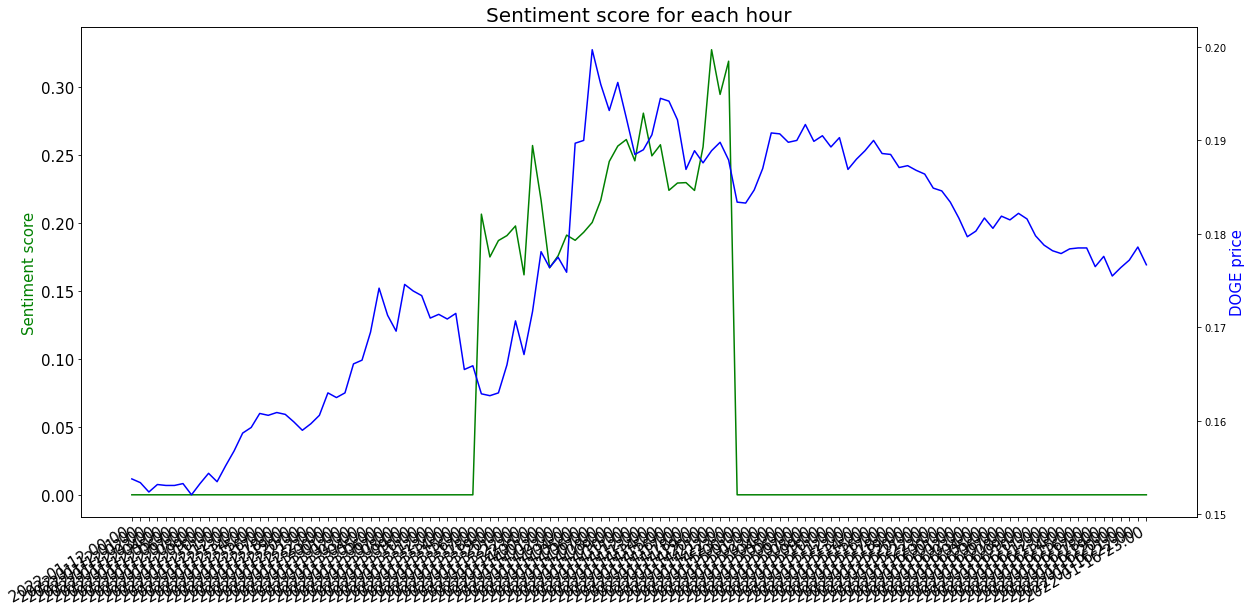

In [201]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Sentiment score for each hour', fontsize=20)
ax.tick_params(labelsize=15)
ax2 = ax.twinx()
ax.plot(doge_price_data['date'], merged_df['sentiment'], color='green')
ax2.plot(doge_price_data['date'], doge_price_data['close'], color='blue')

ax.set_ylabel('Sentiment score', fontsize=15, color='green')
ax2.set_ylabel('DOGE price', fontsize=15, color='blue')


plt.gcf().autofmt_xdate()
plt.show()


### Cross-Correllation analysis
Applying a correlation on the series (tweets' scores and crypto currency) is not enough. That's why we need cross-correlation. The difference is that cross-correlation adds a lag which permit to shift one of the timeseries left or right to find, maybe, a better correlation. This is coherent with our problem as the currency changes come after the tweets' sentiments. So we are fully allowed to operate it.


We can test our correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column.

This Stackoverflow answer gives very useful details about correlating with time series. https://stackoverflow.com/questions/6467832/how-to-get-the-correlation-between-two-timeseries-using-pandas

In [202]:
# Define the cross-correlation function

def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation. 
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corr(datay.shift(lag), method=method)

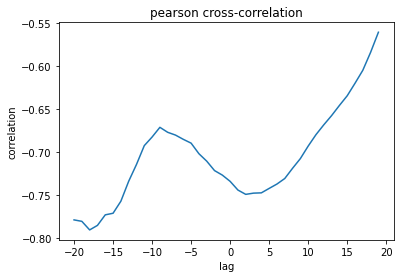

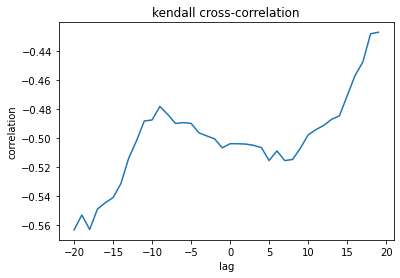

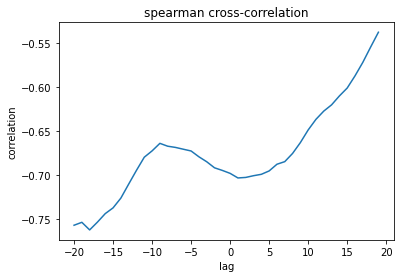

In [203]:
xcov = [crosscorr(merged_df['sentiment'], doge_price_data['close'], lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(merged_df['sentiment'], doge_price_data['close'], lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(merged_df['sentiment'], doge_price_data['close'], lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Normalize data

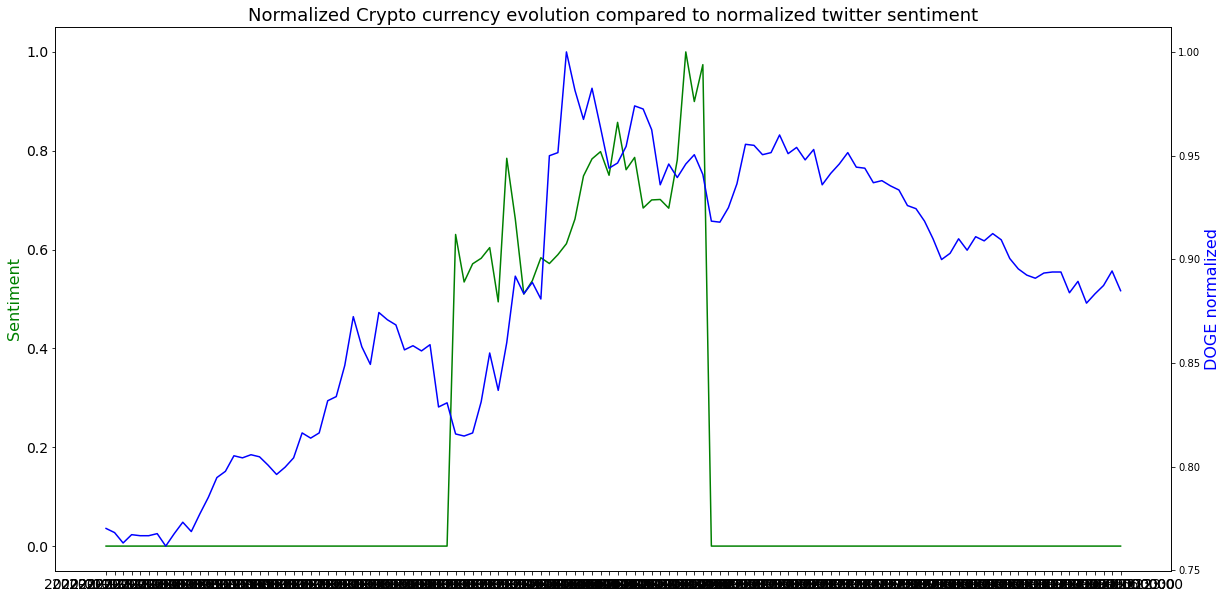

In [206]:
tweets_grouped = merged_df['sentiment'] / max(merged_df['sentiment'].max(), abs(merged_df['sentiment'].min()))
crypto_usd_grouped = doge_price_data['close'] / max(doge_price_data['close'].max(), abs(doge_price_data['close'].min()))

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(doge_price_data['date'], tweets_grouped, 'g-')
ax2.plot_date(doge_price_data['date'], crypto_usd_grouped, 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax2.set_ylabel("DOGE normalized", color='b', fontsize=16)
plt.show()

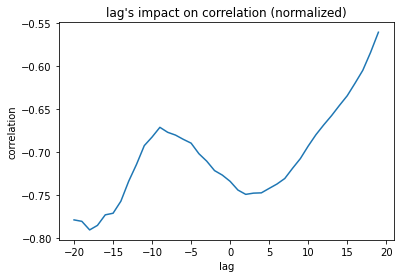

In [207]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

### Change Point detection - algorithm
### Adams and David MacKay algorithm (change point detection)

In [3]:
# Change point detection for the merged dataframe
# import pymc3 as pm

In [2]:
# Create a model
# with pm.Model() as model:
    ## 
    

In [1]:
# Print the posterior of mu
# print(pm.summary(trace))

# # Plot the posterior of mu
# pm.traceplot(trace)